In [14]:
#libraries
import numpy as np
import imageio.v2 as io
import os
from tomopy.recon.algorithm import recon
from tomopy.recon.rotation import write_center as c_o_r
from tomopy.recon.rotation import find_center
from tomopy import circ_mask
from tomopy import minus_log
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
from skimage.filters import median
from skimage.morphology import cube
logging.basicConfig(level=logging.INFO)


#### Step 1 - Nomalise the projections with darks and flats

In [2]:
# load projection data from tiffs in folder
path = 'J:/recon_4scott/21_ILL_SP_before_15mm_15s/Proj'
proj_arr = []
for i in os.listdir(path):
    proj = io.imread(path+'/'+i)
    proj_arr.append(proj)
proj_arr = np.array(proj_arr)[:,700:1200,200:1900]

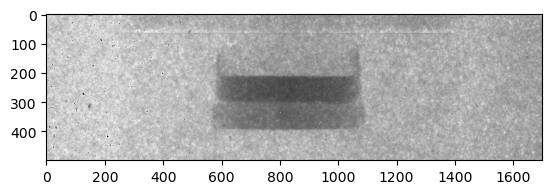

In [3]:
plt.imshow((proj_arr[250]*30).astype(np.uint16), cmap = 'gray')
plt.show()

In [4]:
# load flat and dark
# flat and dark averaging (mean)
# multiple flats and darks are averaged so that variation is taken into account when correction is applied
path_f = 'J:/recon_4scott/20_flats_15mmPinhole_15s'
flat_arr = []
for i in os.listdir(path_f):
    f = io.imread(path_f+'/'+i)
    flat_arr.append(f)
flat_arr = np.array(flat_arr)[:,700:1200,200:1900]
flat_arr = np.mean(flat_arr, 0)
io.imwrite('flat.tiff', flat_arr.astype(np.uint16), format='tiff') # note only converting to 16 bit for save

path_d = 'J:/recon_4scott/22_darks_15mm_15s'
dark_arr = []
for l in os.listdir(path_d):
    d = io.imread(path_d+'/'+l)
    dark_arr.append(d)
dark_arr = np.array(dark_arr)[:,700:1200,200:1900]
dark_arr = np.mean(dark_arr, 0)
io.imwrite('dark.tiff', dark_arr.astype(np.uint16), format='tiff') # note only converting to 16 bit for save

In [10]:
# apply normalisation and save to disk
# here dark flat correction is applied as... normed = (projection - dark_field) / (flat_field - dark_field) 
proj_normed = []
for i in tqdm(range(proj_arr.shape[0])):
    im = (proj_arr[i] - dark_arr)/(flat_arr - dark_arr)
    proj_normed.append(im)
proj_normed = np.array(proj_normed)
io.volwrite('normed_proj.tiff', proj_normed, format='tiff', bigtiff=True)
#proj_normed = minus_log(np.array(proj_normed))

  0%|          | 0/1216 [00:00<?, ?it/s]C:\Users\matti\AppData\Local\Temp\ipykernel_25168\1553077583.py:5: RuntimeWarning: invalid value encountered in divide
  im = (proj_arr[i] - dark_arr)/(flat_arr - dark_arr)
100%|██████████| 1216/1216 [00:14<00:00, 81.32it/s]


In [18]:
# filter the white noise from the image
filt = median(proj_normed, cube(3))
io.volwrite('median_proj.tiff', filt, format='tiff', bigtiff=True)

In [24]:
# removes white noise without smoothing the 'good' data (maybe useful...?)
proj_adapt = np.where(proj_normed - filt > 0.12, filt, proj_normed)

### Step 2 - Define array of acquisition angles for each projection 

In [25]:
angle = 0 
angles = []
for j in range(1216):
    angles.append(angle)
    angle += (360/1215)
angles = np.array(angles)
angles = angles * (np.pi/180)

### Step 3 - Find the Centre of Roatation for the reconstruction 

In [28]:
#proj_normed = (io.volread('normed_proj_8.tiff'))
cor = c_o_r(minus_log(filt), angles, cen_range = [833, 840, 0.5], ind = 350, algorithm = 'fbp')
# Then load data into image viwer and see which centre of rotation is the best and choose best value

INFO:tomopy.recon.algorithm:Reconstructing 14 slice groups with 14 master threads...


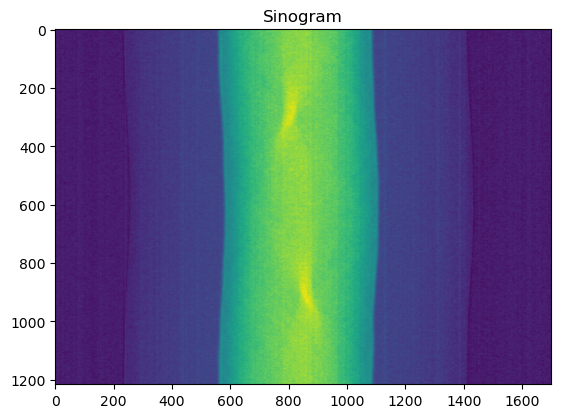

In [36]:
#plot sinogram
plt.imshow(minus_log(filt[:, 350, :]))
plt.title('Sinogram')
plt.show()

In [30]:
#can see at lest one feature in this sino
centre = 832.0

### Step 4 - Reconstruct the projections

In [37]:
recon_1 = recon(minus_log(filt), angles, center = centre, algorithm = 'fbp')
recon = circ_mask(recon_vol, axis=0, ratio=0.95, val = 0)
io.volwrite('recon.tiff', recon_1, format='tiff', bigtiff=True)

INFO:tomopy.recon.algorithm:Reconstructing 24 slice groups with 24 master threads...


In [ ]:
plt.imshow(recon[:, 400, :], cmap = 'gray')
plt.show()

### TO DO:

### TRY BEAMHARDENING CORRECTION, see algotom

### TRY REMOVE STRIPES (SINOGRAMS), see tomopy or algotom